# Download Dataset

Download (10GB) the Military Aircraft Detection Dataset from Kaggle, unzip just the dataset into raw

Total RAW data = 8GB

**IMPORTANT**: Api key (json) from Kaggle needs to be added to the notebooks folder of the project in order to download the dataset

In [1]:
# Check if in a Google Colab
COLAB = False

try:
    import google.colab
    COLAB = True
except ImportError:
    COLAB = False

#### Install Kaggle

In [2]:

! pip install -q kaggle
if COLAB:
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive')
    %cd drive/MyDrive/PAIA/SkyDefender/notebooks

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/marcgaspajoval/.kaggle: File exists


#### Download Dataset

In [5]:
TRUE_CONDITIONS = ['y', 'yes']

# Download the dataset
download = input('\tYes(Y)/No(N): ')

if download.lower() in TRUE_CONDITIONS:
    ! mkdir ./download
    ! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset -p ./download
    # Unzip the dataset
    !mkdir -p ../data/raw
    !mkdir -p ../data/interim
    !unzip -j ../download/militaryaircraftdetectiondataset.zip "dataset/*" -d ./data/raw
    # Remove temporal files?
    !rm -rf ./download

  0%|                                      | 29.0M/10.1G [00:02<13:47, 13.0MB/s]^C
  0%|                                      | 31.0M/10.1G [00:02<13:25, 13.4MB/s]
User cancelled operation
unzip:  cannot find or open ../download/militaryaircraftdetectiondataset.zip, ../download/militaryaircraftdetectiondataset.zip.zip or ../download/militaryaircraftdetectiondataset.zip.ZIP.


## Loading Dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
csv_path = "./data/raw/"
df = pd.concat([pd.read_csv(csv_path + f, delimiter=',') for f in os.listdir(csv_path) if f.endswith('.csv')], ignore_index=True)

In [ ]:
df.to_csv('./data/interim/merged_info.csv', index=False)

## Checking Null Values

In [ ]:
if df.isnull().values.any():
    print("There are null values in DF")
else:
    print("No null values in DF.")

No null values in DF.


## Examining classes

<Axes: ylabel='count'>

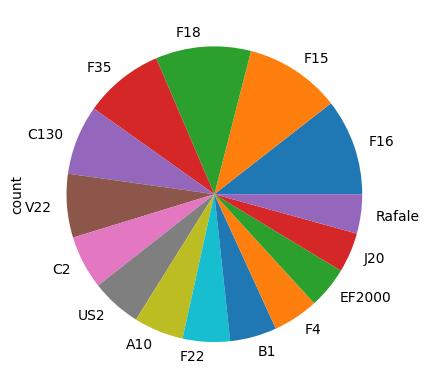

In [ ]:
df["class"].value_counts().head(15).plot(kind="pie") #See where can we reduce a bit our dataset

## Reducing classes
Because the dataset is very large and our project is focused more in object detection, we will be using just 3 classes in order to reduce computing time 

Reduced from 17968 rows to 3162 rows


<Axes: ylabel='count'>

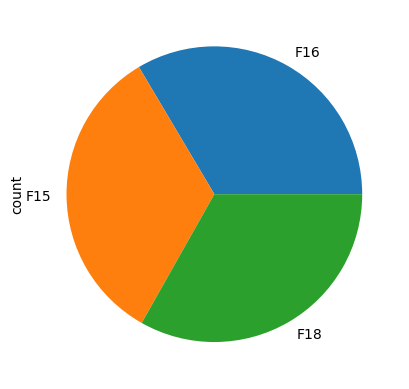

In [ ]:
target = ["F16", "F15", "F18"] #Classes we want to keep

df_reduced = df.loc[df["class"].isin(target)].copy(deep=True)

print(f"Reduced from {len(df.index)} rows to {len(df_reduced.index)} rows")
df_reduced["class"].value_counts().plot(kind="pie")

# Loading images

## Adding paths to images

In [ ]:
# Image location
images_dir = '../data/raw/'

df_clean = df_reduced.copy(deep = True)

# Add the filepath to the image into the dataframe
df_clean['filepath'] = images_dir + df['filename'] + '.jpg'
df_clean.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,filepath
0,c63ae96d05c500d4ab9806f3ae58e122,2048,1365,F16,193,372,826,984,./data/raw/c63ae96d05c500d4ab9806f3ae58e122.jpg
4,43139586ca5df4d371243edff3ccc042,1800,1200,F15,1349,959,1475,993,./data/raw/43139586ca5df4d371243edff3ccc042.jpg
9,5f57bc06c34226b3f371ba5bab097b1c,1800,1200,F18,138,195,193,217,./data/raw/5f57bc06c34226b3f371ba5bab097b1c.jpg
10,5f57bc06c34226b3f371ba5bab097b1c,1800,1200,F18,1257,382,1342,418,./data/raw/5f57bc06c34226b3f371ba5bab097b1c.jpg
33,bc02bc3564f44267ef9ff6baa4dfbede,1800,1200,F15,87,179,727,583,./data/raw/bc02bc3564f44267ef9ff6baa4dfbede.jpg


## Normalize images and bounding boxes

In [ ]:
df_img = df_clean.copy(deep = True)
height = 256
width = 256
# Iteración sobre el dataframe
for index, row in df_clean.iterrows():
    # Leer la ruta de la imagen del dataframe
    filepath = row['filepath']
    
    # Cargar la imagen utilizando TensorFlow
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(height, width))  # Ajusta height y width a tus dimensiones deseadas
    
    # Convertir la imagen a un arreglo numpy
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalizar los valores de píxel a un rango entre 0 y 1
    img_array /= 255.0
    
    # Calcular las coordenadas normalizadas
    x_min = row['xmin'] / width
    y_min = row['ymin'] / height
    x_max = row['xmax'] / width
    y_max = row['ymax'] / height
    
    # Obtener la etiqueta de clase
    label = row['class']
    
    # Guardar las coordenadas normalizadas y la etiqueta en el dataframe
    df_img.at[index, 'x_min_norm'] = x_min
    df_img.at[index, 'y_min_norm'] = y_min
    df_img.at[index, 'x_max_norm'] = x_max
    df_img.at[index, 'y_max_norm'] = y_max
    df_img.at[index, 'label'] = label

## Train Test Split

In [ ]:
#Create Train and Test sets
train_dfs = []
test_dfs = []

grouped = df_clean.groupby('class') 

for category, group_df in grouped:
    # Divide the sets
    train_df, test_df = train_test_split(group_df, test_size=0.2, random_state=42) #For each group, we set an 80% train 20%test
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [ ]:
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

In [ ]:
print(test_df.head())
print("------------------------")
print("Total: " + str(len(test_df)))

In [ ]:
print(train_df.head())
print("------------------------")
print("Total: "+ str(len(train_df)))